# Recommendation System Project: IBM Community

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/3325/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t


df = pd.read_csv(
    'data/user-item-interactions.csv', 
    dtype={'article_id': int, 'title': str, 'email': str}
)
# Show df to get an idea of the data
df.head()

,Unnamed: 0,article_id,title,email
0,0,1430,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1,1314,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,2,1429,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,3,1338,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,4,1276,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` Are there any missing values? If so, provide a count of missing values. If there are missing values in `email`, assign it the same id value `"unknown_user"`.

In [2]:
# Some interactions do not have a user associated with it, assume the same user.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  45993 non-null  int64 
 1   article_id  45993 non-null  int32 
 2   title       45993 non-null  object
 3   email       45976 non-null  object
dtypes: int32(1), int64(1), object(2)
memory usage: 1.2+ MB


In [3]:
print(f"Number of Null email values is: {df['email'].isnull().sum()}")

Number of Null email values is: 17


In [4]:
df[df.email.isna()]

,Unnamed: 0,article_id,title,email
25131,25146,1016,why you should master r (even if it might even...,NaN
29758,30157,1393,the nurse assignment problem,NaN
29759,30158,20,working interactively with rstudio and noteboo...,NaN
29760,30159,1174,breast cancer wisconsin (diagnostic) data set,NaN
29761,30160,62,data visualization: the importance of excludin...,NaN
35264,36016,224,"using apply, sapply, lapply in r",NaN
35276,36029,961,beyond parallelize and collect,NaN
35277,36030,268,sector correlations shiny app,NaN
35278,36031,268,sector correlations shiny app,NaN
35279,36032,268,sector correlations shiny app,NaN


In [5]:
# Fill email NaNs with "unknown_user"
df['email'] = df['email'].fillna('unknown_user')

In [6]:
# Check if no more NaNs 
df[df.email.isna()]

,Unnamed: 0,article_id,title,email


`2.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.

In [7]:
# What are the descriptive statistics of the number of articles a user interacts with?
# Calculate the number of articles each user interacted with
# Calculate the number of articles each user (email) interacted with
user_interactions = df.groupby('email')['article_id'].count()

# Descriptive statistics
stats = user_interactions.describe()

# Print descriptive statistics
print(stats)

count    5149.000000
mean        8.932414
std        16.801011
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64


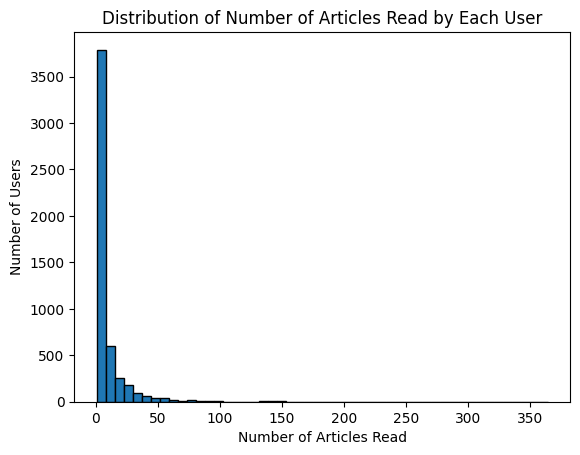

In [8]:
# Create a plot of the number of articles read by each user

# Create a plot of the number of articles read by each user
plt.hist(user_interactions, bins=50, edgecolor='black')
plt.xlabel('Number of Articles Read')
plt.ylabel('Number of Users')
plt.title('Distribution of Number of Articles Read by Each User')
plt.show()

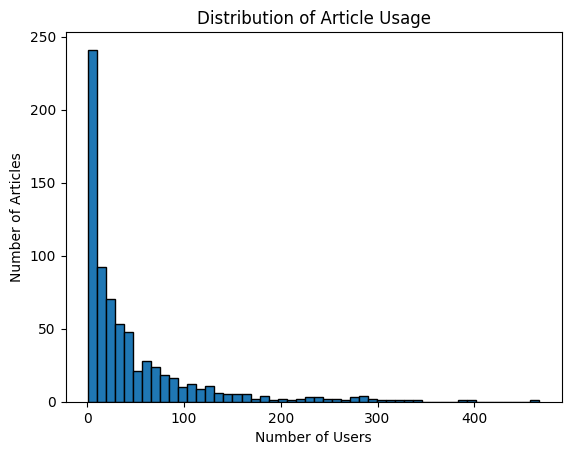

In [9]:
# Calculate the number of users who interacted with each article
article_interactions = df.groupby('article_id')['email'].nunique()

# Create a plot of the number of times each article was read
plt.hist(article_interactions, bins=50, edgecolor='black')
plt.xlabel('Number of Users')
plt.ylabel('Number of Articles')
plt.title('Distribution of Article Usage')
plt.show()

In [10]:
# Calculate the number of articles each user interacted with
user_interactions = df.groupby('email')['article_id'].count()

# Calculate the median and maximum number of user-article interactions
median_val = user_interactions.median()
max_views_by_user = user_interactions.max()

# Print the results
print(f"Median number of articles: {median_val}")
print(f"Maximum number of articles by a user: {max_views_by_user}")


Median number of articles: 3.0
Maximum number of articles by a user: 364


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [11]:
# The number of unique articles that have at least one interaction
unique_articles = df['article_id'].nunique()

# The number of unique articles in the dataset (total articles in the platform)
total_articles = df['article_id'].nunique()

# The number of unique users
unique_users = df['email'].nunique()

# The number of user-article interactions (total interactions in the dataset)
user_article_interactions = len(df)

# Print the results
print(f"Unique articles with at least one interaction: {unique_articles}")
print(f"Total number of articles on the platform: {total_articles}")
print(f"Unique users: {unique_users}")
print(f"Total number of user-article interactions: {user_article_interactions}")


Unique articles with at least one interaction: 714
Total number of articles on the platform: 714
Unique users: 5149
Total number of user-article interactions: 45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [12]:
# Find the most viewed article id
most_viewed_article_id = df['article_id'].value_counts().idxmax()

# Find the maximum number of views (interactions) for any article
max_views = df['article_id'].value_counts().max()

# Print the results
print(f"Most viewed article ID: {most_viewed_article_id}")
print(f"Maximum number of views for an article: {max_views}")

Most viewed article ID: 1429
Maximum number of views for an article: 937


In [13]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper(df=df):
    coded_dict = {
        email: num 
        for num, email in enumerate(df['email'].unique(), start=1)
    }
    return [coded_dict[val] for val in df['email']]

df['user_id'] = email_mapper(df)
del df['email']

# show header
df.head()

,Unnamed: 0,article_id,title,user_id
0,0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1,1314,healthcare python streaming application demo,2
2,2,1429,use deep learning for image classification,3
3,3,1338,ml optimization using cognitive assistant,4
4,4,1276,deploy your python model as a restful api,5


In [14]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

In this project, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article. In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [15]:
def get_top_articles(n, df=df):
    """
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    """
    # Count the interactions for each article
    article_counts = df['article_id'].value_counts()
    
    # Get the top n article ids
    top_article_ids = article_counts.head(n).index.tolist()
    
    # Get the corresponding article titles
    top_articles = df[df['article_id'].isin(top_article_ids)]['title'].unique().tolist()
    
    return top_articles  # Return the top article titles


def get_top_article_ids(n, df=df):
    """
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article ids 
    
    """
    # Count the interactions for each article
    article_counts = df['article_id'].value_counts()
    
    # Get the top n article ids
    top_article_ids = article_counts.head(n).index.tolist()
    
    return top_article_ids  # Return the top article ids

# Example test
top_articles = get_top_articles(10)
top_article_ids = get_top_article_ids(10)

print("Top 10 Articles Titles:", top_articles)
print("Top 10 Article IDs:", top_article_ids)

Top 10 Articles Titles: ['healthcare python streaming application demo', 'use deep learning for image classification', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'finding optimal locations of new store using decision optimization']
Top 10 Article IDs: [1429, 1330, 1431, 1427, 1364, 1314, 1293, 1170, 1162, 1304]


In [16]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['healthcare python streaming application demo', 'use deep learning for image classification', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'finding optimal locations of new store using decision optimization']
[1429, 1330, 1431, 1427, 1364, 1314, 1293, 1170, 1162, 1304]


In [17]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [18]:
def create_user_item_matrix(df, fill_value=0):
    """
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    """
    # Update 'email' to the correct user identifier column, such as 'user_id' or whatever the correct column name is.
    user_item = df.pivot_table(index='user_id', columns='article_id', aggfunc='size', fill_value=fill_value)
    
    # Replace values greater than 0 with 1 (indicating interaction)
    user_item = user_item.applymap(lambda x: 1 if x > 0 else 0)
    
    return user_item

# Create the user-item matrix
user_item = create_user_item_matrix(df)

# Display the resulting user-item matrix
print(user_item.head())

C:\Users\Nandan\AppData\Local\Temp\ipykernel_24980\1136465905.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  user_item = user_item.applymap(lambda x: 1 if x > 0 else 0)


article_id  0     2     4     8     9     12    14    15    16    18    ...  \
user_id                                                                 ...   
1              0     0     0     0     0     0     0     0     0     0  ...   
2              0     0     0     0     0     0     0     0     0     0  ...   
3              0     0     0     0     0     1     0     0     0     0  ...   
4              0     0     0     0     0     0     0     0     0     0  ...   
5              0     0     0     0     0     0     0     0     0     0  ...   

article_id  1434  1435  1436  1437  1439  1440  1441  1442  1443  1444  
user_id                                                                 
1              0     0     1     0     1     0     0     0     0     0  
2              0     0     0     0     0     0     0     0     0     0  
3              0     0     1     0     0     0     0     0     0     0  
4              0     0     0     0     0     0     0     0     0     0  
5       

In [19]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [20]:
# Lets use the cosine_similarity function from sklearn
from sklearn.metrics.pairwise import cosine_similarity

In [21]:
print(user_item.index)

Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
       ...
       5140, 5141, 5142, 5143, 5144, 5145, 5146, 5147, 5148, 5149],
      dtype='int64', name='user_id', length=5149)


In [22]:
def find_similar_users(user_id, user_item, include_similarity=False):
    """
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    include_similarity - (bool) whether to include the similarity in the output
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered list of user ids. If include_similarity is True, returns a list of lists
    where the first element is the user id and the second the similarity.
    """
    
    # Get the index of the user in the user-item matrix
    user_idx = user_item.index.get_loc(user_id)
    
    # Compute cosine similarity between the provided user and all others (dot product approach)
    cosine_similarities = cosine_similarity(user_item.iloc[user_idx:user_idx+1], user_item)
    
    # Get the similarity scores as a list of tuples (user_index, similarity_score)
    similarities = list(enumerate(cosine_similarities[0]))
    
    # Remove the similarity score for the user itself
    similarities = [user for user in similarities if user[0] != user_idx]
    
    # Sort the users based on the similarity score in descending order
    sorted_similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
    
    # Create a list of just the user ids (sorted by similarity)
    most_similar_users = [user_item.index[user[0]] for user in sorted_similarities]
    
    if include_similarity:
        # Return list of lists with [[user_id, similarity], ...]
        return [[user_item.index[user[0]], user[1]] for user in sorted_similarities]
    
    return most_similar_users

# Example usage:
user_id = 123  # example user_id as an integer
similar_users = find_similar_users(user_id, user_item, include_similarity=True)

# Print the results
print(similar_users)

[[93, 1.0], [128, 1.0], [818, 1.0], [1077, 1.0], [1164, 1.0], [1371, 1.0], [1495, 1.0], [1624, 1.0], [1675, 1.0], [1697, 1.0], [1892, 1.0], [1930, 1.0], [1966, 1.0], [2018, 1.0], [3661, 1.0], [4602, 1.0], [5112, 1.0], [18, 0.7071067811865475], [177, 0.7071067811865475], [657, 0.7071067811865475], [903, 0.7071067811865475], [1239, 0.7071067811865475], [1420, 0.7071067811865475], [1631, 0.7071067811865475], [1781, 0.7071067811865475], [1929, 0.7071067811865475], [2048, 0.7071067811865475], [2097, 0.7071067811865475], [2770, 0.7071067811865475], [3122, 0.7071067811865475], [3132, 0.7071067811865475], [4435, 0.7071067811865475], [4614, 0.7071067811865475], [16, 0.5773502691896258], [724, 0.5773502691896258], [894, 0.5773502691896258], [947, 0.5773502691896258], [1074, 0.5773502691896258], [1359, 0.5773502691896258], [1375, 0.5773502691896258], [1483, 0.5773502691896258], [1541, 0.5773502691896258], [1561, 0.5773502691896258], [1635, 0.5773502691896258], [1882, 0.5773502691896258], [2969, 0

In [23]:
user_id = 123  # Use integer user_id
similar_users = find_similar_users(user_id, user_item, include_similarity=True)

# Print the results
print(similar_users)

[[93, 1.0], [128, 1.0], [818, 1.0], [1077, 1.0], [1164, 1.0], [1371, 1.0], [1495, 1.0], [1624, 1.0], [1675, 1.0], [1697, 1.0], [1892, 1.0], [1930, 1.0], [1966, 1.0], [2018, 1.0], [3661, 1.0], [4602, 1.0], [5112, 1.0], [18, 0.7071067811865475], [177, 0.7071067811865475], [657, 0.7071067811865475], [903, 0.7071067811865475], [1239, 0.7071067811865475], [1420, 0.7071067811865475], [1631, 0.7071067811865475], [1781, 0.7071067811865475], [1929, 0.7071067811865475], [2048, 0.7071067811865475], [2097, 0.7071067811865475], [2770, 0.7071067811865475], [3122, 0.7071067811865475], [3132, 0.7071067811865475], [4435, 0.7071067811865475], [4614, 0.7071067811865475], [16, 0.5773502691896258], [724, 0.5773502691896258], [894, 0.5773502691896258], [947, 0.5773502691896258], [1074, 0.5773502691896258], [1359, 0.5773502691896258], [1375, 0.5773502691896258], [1483, 0.5773502691896258], [1541, 0.5773502691896258], [1561, 0.5773502691896258], [1635, 0.5773502691896258], [1882, 0.5773502691896258], [2969, 0

In [24]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1, user_item)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933, user_item)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46, user_item)[:3]))

The 10 most similar users to user 1 are: [3933, 46, 4201, 253, 824, 5034, 5041, 136, 2305, 395]
The 5 most similar users to user 3933 are: [1, 46, 4201, 253, 824]
The 3 most similar users to user 46 are: [4201, 790, 5077]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [25]:
def get_article_names(article_ids, df=df):
    """
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column in df)
    """
    # Extract article titles from the df based on the given article_ids
    article_names = df[df['article_id'].isin(article_ids)]['title'].tolist()
    
    return article_names  # Return the article names associated with the list of article ids

In [26]:
def get_ranked_article_unique_counts(article_ids, user_item=user_item):
    """
    INPUT:
    article_ids - (list) a list of article ids
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise 
    
    OUTPUT:
    article_counts - (list) a list of tuples with article_id and number of 
                     unique users that have interacted with the article, sorted
                     by the number of unique users in descending order
    
    Description:
    Provides a list of the article_ids and the number of unique users that have
    interacted with the article using the user_item matrix, sorted by the number
    of unique users in descending order
    """
    # Count unique users per article (sum the rows for each article)
    article_counts = user_item[article_ids].sum(axis=0).reset_index()
    article_counts.columns = ['article_id', 'user_count']
    
    # Sort by the number of unique users in descending order
    ranked_article_unique_counts = article_counts.sort_values(by='user_count', ascending=False)
    
    return ranked_article_unique_counts.values.tolist()  # Return sorted list of article_id and user_count


In [27]:
def get_user_articles(user_id, user_item=user_item):
    """
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column in df)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    """
    # Get the list of articles the user has interacted with
    article_ids = user_item.columns[user_item.loc[user_id] == 1].tolist()
    
    # Get the article names corresponding to the article_ids
    article_names = get_article_names(article_ids, df)
    
    return article_ids, article_names  # Return the ids and names


In [ ]:
def user_user_recs(user_id, m=10):
    """
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    """
    # Get the most similar users
    similar_users = find_similar_users(user_id, user_item, include_similarity=False)
    
    # Get the articles that the input user has already seen
    user_articles, _ = get_user_articles(user_id, user_item)
    
    recs = []
    
    # Loop through similar users to find recommendations
    for similar_user in similar_users:
        # Get the articles that the similar user has seen
        similar_user_articles, _ = get_user_articles(similar_user, user_item)
        
        # Filter out articles that the input user has already seen
        new_articles = [article for article in similar_user_articles if article not in user_articles]
        
        # Add the new articles to recommendations
        recs.extend(new_articles)
        
        # If we've found enough recommendations, break the loop
        if len(recs) >= m:
            break
    
    # If there are too many, limit the recommendations to the first m articles
    recs = recs[:m]
    
    return recs  # Return the list of recommended articles for the user


In [29]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['leverage python, scikit, and text classification for behavioral profiling',
 'leverage python, scikit, and text classification for behavioral profiling',
 'challenges in deep learning',
 'awesome deep learning papers',
 'leverage python, scikit, and text classification for behavioral profiling',
 'leverage python, scikit, and text classification for behavioral profiling',
 'leverage python, scikit, and text classification for behavioral profiling',
 'leverage python, scikit, and text classification for behavioral profiling',
 'leverage python, scikit, and text classification for behavioral profiling',
 'awesome deep learning papers',
 'this week in data science (april 18, 2017)',
 'this week in data science (april 18, 2017)',
 'leverage python, scikit, and text classification for behavioral profiling',
 'leverage python, scikit, and text classification for behavioral profiling',
 'improving the roi of big data and analytics through leveraging new sources of data',
 'this week in data

In [30]:
get_ranked_article_unique_counts([1320, 232, 844])

[[1320, 123], [844, 78], [232, 62]]

In [31]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names([1024, 1176, 1305, 1314, 1422, 1427])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names([1320, 232, 844])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set([1320, 232, 844])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set([1024, 1176, 1305, 1314, 1422, 1427])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
assert get_ranked_article_unique_counts([1320, 232, 844])[0] == [1320, 123], "Oops! Your the get_ranked_article_unique_counts function doesn't work quite how we expect.\nMake sure you are using the user_item matrix to create the article counts."
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [32]:
def get_top_sorted_users(user_id, user_item=user_item):
    """
    INPUT:
    user_id - (int)
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user
    """
    # Compute similarity between the given user and all others
    similar_users = find_similar_users(user_id, user_item, include_similarity=True)
    
    # Convert to a dataframe for easier manipulation
    neighbors_df = pd.DataFrame(similar_users, columns=['neighbor_id', 'similarity'])
    
    # Add the number of interactions for each neighbor (how many articles they have interacted with)
    neighbors_df['num_interactions'] = neighbors_df['neighbor_id'].apply(lambda x: user_item.loc[x].sum())
    
    # Sort by similarity (descending), and by number of interactions (descending) for users with equal similarity
    neighbors_df = neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=[False, False])
    
    return neighbors_df  # Return the sorted dataframe with neighbors' similarity and number of interactions


In [33]:
def user_user_recs_part2(user_id, m=10):
    """
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
    """
    # Get the sorted list of users based on similarity and number of interactions
    top_users_df = get_top_sorted_users(user_id, user_item)
    
    # Get the articles the input user has already interacted with
    user_articles, _ = get_user_articles(user_id, user_item)
    
    # Initialize an empty list for the recommendations
    recs = []
    
    # Iterate through the top users and gather articles they have interacted with that the input user hasn't seen
    for _, row in top_users_df.iterrows():
        neighbor_id = row['neighbor_id']
        
        # Get articles this similar user has interacted with
        neighbor_articles, _ = get_user_articles(neighbor_id, user_item)
        
        # Filter out articles the input user has already seen
        new_articles = [article for article in neighbor_articles if article not in user_articles]
        
        # Add the new articles to the recommendations list
        recs.extend(new_articles)
        
        # Stop if we've reached the desired number of recommendations
        if len(recs) >= m:
            break
    
    # Limit the recommendations to the top m articles
    recs = recs[:m]
    
    # Get the article names corresponding to the recommended article ids
    rec_names = get_article_names(recs, df)
    
    return recs, rec_names  # Return the article ids and their corresponding names


In [34]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1162, 1165, 1185, 1293, 254, 1165, 1185, 1293, 40, 1271]

The top 10 recommendations for user 20 are the following article names:
['classify tumors with machine learning', 'analyze energy consumption in buildings', 'analyze energy consumption in buildings', 'analyze energy consumption in buildings', 'analyze energy consumption in buildings', 'analyze energy consumption in buildings', 'analyze energy consumption in buildings', 'analyze energy consumption in buildings', 'analyze energy consumption in buildings', 'analyze precipitation data', 'analyze precipitation data', 'classify tumors with machine learning', 'finding optimal locations of new store using decision optimization', 'finding optimal locations of new store using decision optimization', 'analyze energy consumption in buildings', 'finding optimal locations of new store using decision optimization', 'analyze energy consumption in buildings', 'analyze energy 

`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [35]:
print(get_top_sorted_users(1, user_item=user_item).head(n=1))
print(get_top_sorted_users(2, user_item=user_item).head(n=10))
print(get_top_sorted_users(131, user_item=user_item).head(n=10))

   neighbor_id  similarity  num_interactions
0         3933    0.986013                35
    neighbor_id  similarity  num_interactions
0          5083    0.730297                 5
1          1552    0.577350                 2
2          1890    0.577350                 2
3          1372    0.471405                 3
4          2941    0.433013                 8
37         3586    0.408248                 4
5           331    0.408248                 1
6           348    0.408248                 1
7           378    0.408248                 1
8           496    0.408248                 1
   neighbor_id  similarity  num_interactions
0         3870    0.986667                75
1          203    0.388909                96
2         4459    0.388909                96
3         3782    0.387585               135
4           40    0.384308                52
5         4932    0.384308                52
6           23    0.377647               135
7          242    0.375823                59

In [36]:
# Find the user that is most similar to user 1
user1_most_sim = find_similar_users(1, user_item)[0]  # The most similar user to user 1 is at index 0
print(f"Most similar user to user 1: {user1_most_sim}")

# Find the 6th most similar user to user 2
user2_6th_sim = find_similar_users(2, user_item)[5]  # The 6th most similar user to user 2 is at index 5
print(f"6th most similar user to user 2: {user2_6th_sim}")

# Find the 10th most similar user to user 131
user131_10th_sim = find_similar_users(131, user_item)[9]  # The 10th most similar user to user 131 is at index 9
print(f"10th most similar user to user 131: {user131_10th_sim}")

Most similar user to user 1: 3933
6th most similar user to user 2: 331
10th most similar user to user 131: 383


In [37]:
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 6th most similar to user 2.': 3586,
    'The user that is the 10th most similar to user 131.': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

Answer:

When dealing with a new user—one who hasn't interacted with any articles yet—there are a few challenges in terms of recommending content, because the methods we've developed rely heavily on user interaction data. Specifically, functions like find_similar_users and user_user_recs require at least some interaction data to function properly, and they depend on the assumption that users share similar interests based on their past behaviors.

Functions to Use for a New User:
For a new user, the following approach could still be utilized, albeit with some limitations:

User-Item Matrix: If the new user hasn't interacted with any articles, they would have no record in the user-item matrix. Therefore, functions like find_similar_users would return no useful data for the new user.

Article Recommendations: One approach could be recommending articles that are popular among existing users, based on the total number of interactions with each article. This can be done using the get_top_sorted_articles function, which ranks articles based on their popularity. The assumption here is that a new user is likely to appreciate popular content, as it has broad appeal.

Better Method for New Users: Content-Based Filtering
A more effective approach for recommending articles to new users would be to use content-based filtering. Here's how you might approach it:

Article Features: Gather and analyze features related to each article (e.g., categories, keywords, topics). For instance, each article could have metadata such as:

Category (e.g., finance, tech, health, etc.)

Keywords/Tags (e.g., machine learning, investment, insurance)

Article length

Author or source

New User Preferences: Instead of relying on interaction history, you can ask the new user a few questions to capture their preferences, such as:

Which categories of articles do they prefer? (Finance, Tech, Lifestyle, etc.)

Are there specific topics or keywords they are interested in?

Article Matching: Use the user's preferences to recommend articles that match those features. For example, if the user likes articles related to "tech" and "machine learning," you can filter out and suggest articles that belong to these categories or include these keywords.

Hybrid Model: Combine the content-based filtering method with a collaborative filtering method (based on user similarity), so that once the user starts interacting with the articles, they can be integrated into the collaborative model. Initially, they might rely more on the content-based approach, but as their interaction data grows, collaborative filtering can be used to refine the recommendations.

How to Implement a Content-Based Filtering System:
Step 1: Build a content-based profile for each article using the available metadata or keywords.

Step 2: Ask the user to fill out a survey or preferences form to create their profile.

Step 3: Filter articles that align with the new user's profile.

Step 4: Recommend those filtered articles to the new user.

This method doesn't require any past interaction data, and it leverages the content itself to make meaningful recommendations to a new user. Over time, as the user starts interacting with articles, you can gradually introduce collaborative filtering to refine the recommendations based on the user's behavior.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [38]:
def get_top_sorted_articles(user_item=user_item):
    """
    Get articles sorted by the number of interactions (in descending order).
    
    INPUT:
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    sorted_articles - (list) a list of tuples with article_ids and their corresponding 
                      number of interactions, sorted by the number of interactions.
    """
    # Sum up interactions for each article (column-wise)
    article_interactions = user_item.sum(axis=0)
    
    # Sort articles by number of interactions in descending order
    sorted_articles = article_interactions.sort_values(ascending=False)
    
    # Return the article ids and their interaction counts
    return sorted_articles.index.tolist(), sorted_articles.values.tolist()

# Now get the top 10 recommended articles for the new user
new_user_recs = get_top_sorted_articles()[0][:10]  # Extract the top 10 article ids
print(f"Top 10 recommended article IDs for new user: {new_user_recs}")


Top 10 recommended article IDs for new user: [1330, 1429, 1364, 1314, 1398, 1431, 1271, 1427, 1160, 43]


In [39]:
# What would your recommendations be for this new user 0?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 

# Get the top 10 recommended articles for the new user
new_user_recs = get_top_sorted_articles()[0][:10] 
print(f"Top 10 recommended article IDs for new user: {new_user_recs}")


Top 10 recommended article IDs for new user: [1330, 1429, 1364, 1314, 1398, 1431, 1271, 1427, 1160, 43]


In [40]:
print(f"Top 10 recommended article IDs for new user: {new_user_recs}")

Top 10 recommended article IDs for new user: [1330, 1429, 1364, 1314, 1398, 1431, 1271, 1427, 1160, 43]


In [41]:
assert set(new_user_recs) == {1330, 1429, 1364, 1314, 1398, 1431, 1271, 1427, 1160, 43}, "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations</a>

Another method we might use to make recommendations is to recommend similar articles that are possibly related. One way we can find article relationships is by clustering text about those articles.  Let's consider content to be the article **title**, as it is the only text we have available. One point to highlight, there isn't one way to create a content based recommendation, especially considering that text information can be processed in many ways.  

`1.` Use the function bodies below to create a content based recommender function `make_content_recs`. We'll use TF-IDF to create a matrix based off article titles, and use this matrix to create clusters of related articles. You can use this function to make recommendations of new articles.

In [42]:
df.head()

,Unnamed: 0,article_id,title,user_id
0,0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1,1314,healthcare python streaming application demo,2
2,2,1429,use deep learning for image classification,3
3,3,1338,ml optimization using cognitive assistant,4
4,4,1276,deploy your python model as a restful api,5


In [43]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD

In [44]:
# unique articles
df_unique_articles = df[['article_id', 'title']].drop_duplicates()

In [45]:
# Create a vectorizer using TfidfVectorizer and fit it to the article titles
max_features = 200
max_df = 0.75
min_df = 5

vectorizer = TfidfVectorizer(
    max_df=max_df,
    min_df=min_df,
    stop_words="english",
    max_features=max_features,
)
print("Running TF-IDF")
X_tfidf =  vectorizer.fit_transform(df['title']) # Fit the vectorizer to the article titles

print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

lsa = make_pipeline(TruncatedSVD(n_components=50), Normalizer(copy=False))
X_lsa = lsa.fit_transform(X_tfidf)# Fit the LSA model to the vectorized article titles
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

Running TF-IDF
n_samples: 45993, n_features: 200
Explained variance of the SVD step: 71.3%


In [53]:
df_unique_articles = df.drop_duplicates('article_id').reset_index(drop=True)

In [54]:
df_unique_articles = df[['article_id', 'title']].drop_duplicates().reset_index(drop=True)

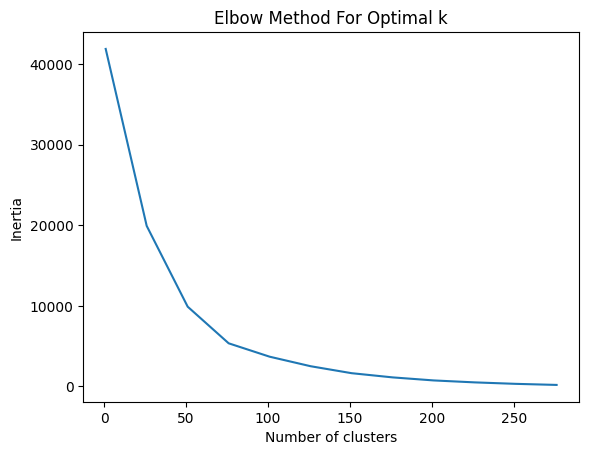

In [51]:
# Parameters
inertia = []
clusters = 300  # maximum number of clusters to test
step = 25  # step size between the number of clusters
max_iter = 50  # maximum number of iterations for KMeans
n_init = 5  # number of initializations for KMeans
random_state = 42  # for reproducibility

# Loop over different numbers of clusters
for k in range(1, clusters, step):
    kmeans = KMeans(
        n_clusters=k,
        max_iter=max_iter,
        n_init=n_init,
        random_state=random_state,
    ).fit(X_lsa)  # X_lsa is the LSA transformed data
    # Append the inertia (sum of squared distances to closest cluster center)
    inertia.append(kmeans.inertia_)

# Plotting the inertia for different numbers of clusters
plt.plot(range(1, clusters, step), inertia)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

There appears to be an elbow about 50, so we'll use 50 clusters.

In [57]:
# 1. Create df_unique_articles
df_unique_articles = df[['article_id', 'title']].drop_duplicates('article_id').reset_index(drop=True)

# 2. Recreate X_lsa using ONLY the unique articles
# Import required
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# 2.1 TF-IDF
tfidf = TfidfVectorizer(stop_words='english')
X_tfidf = tfidf.fit_transform(df_unique_articles['title'])

# 2.2 LSA (SVD)
svd = TruncatedSVD(n_components=100, random_state=42)
X_lsa = svd.fit_transform(X_tfidf)

# 3. Now KMeans clustering on X_lsa
n_clusters = 50
kmeans = KMeans(
    n_clusters=n_clusters,
    max_iter=50,
    n_init=5,
    random_state=42
)
kmeans.fit(X_lsa)

# 4. Assign cluster labels
df_unique_articles['cluster'] = kmeans.labels_

# 5. Check
print(df_unique_articles.head())


   article_id                                              title  cluster
0        1430  using pixiedust for fast, flexible, and easier...        9
1        1314       healthcare python streaming application demo       29
2        1429         use deep learning for image classification       11
3        1338          ml optimization using cognitive assistant        9
4        1276          deploy your python model as a restful api       18


In [58]:
# Map article_id to its corresponding cluster label
article_cluster_map = dict(zip(df_unique_articles['article_id'], df_unique_articles['cluster']))

# Apply the map to create a new column 'title_cluster' in the original df
df['title_cluster'] = df['article_id'].map(article_cluster_map)

# Display the updated df to check the new column
print(df.head())


   Unnamed: 0  article_id                                              title  \
0           0        1430  using pixiedust for fast, flexible, and easier...   
1           1        1314       healthcare python streaming application demo   
2           2        1429         use deep learning for image classification   
3           3        1338          ml optimization using cognitive assistant   
4           4        1276          deploy your python model as a restful api   

   user_id  title_cluster  
0        1              9  
1        2             29  
2        3             11  
3        4              9  
4        5             18  


In [59]:
# Let's check the number of articles in each cluster
np.array(np.unique(kmeans.labels_, return_counts=True)).T

array([[  0,   1],
       [  1,   1],
       [  2,  17],
       [  3,   9],
       [  4,  19],
       [  5,  45],
       [  6,  10],
       [  7,  34],
       [  8,  26],
       [  9,  22],
       [ 10,  20],
       [ 11,  21],
       [ 12,   6],
       [ 13,  10],
       [ 14,  15],
       [ 15,  14],
       [ 16,  43],
       [ 17,  18],
       [ 18,  10],
       [ 19,  22],
       [ 20,  14],
       [ 21,   7],
       [ 22,  23],
       [ 23,   5],
       [ 24,   2],
       [ 25,  13],
       [ 26,   5],
       [ 27,   4],
       [ 28,   6],
       [ 29,  26],
       [ 30,   3],
       [ 31,   5],
       [ 32,   4],
       [ 33, 133],
       [ 34,   6],
       [ 35,   7],
       [ 36,   3],
       [ 37,  19],
       [ 38,   3],
       [ 39,   2],
       [ 40,   5],
       [ 41,   5],
       [ 42,   3],
       [ 43,   7],
       [ 44,  10],
       [ 45,   3],
       [ 46,   7],
       [ 47,   5],
       [ 48,   6],
       [ 49,  10]], dtype=int64)

In [60]:
def get_similar_articles(article_id, df=df):
    """
    INPUT:
    article_id - (int) an article id 
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    article_ids - (list) a list of article ids that are in the same title cluster
    
    Description:
    Returns a list of the article ids that are in the same title cluster
    """
    # Step 1: Find the title cluster of the given article
    title_cluster = df.loc[df['article_id'] == article_id, 'title_cluster'].values[0]
    
    # Step 2: Find all articles in the same title cluster
    articles_in_cluster = df.loc[df['title_cluster'] == title_cluster, 'article_id'].tolist()
    
    # Step 3: Remove the input article_id from the list
    articles_in_cluster = [article for article in articles_in_cluster if article != article_id]
    
    return articles_in_cluster

In [82]:
def make_content_recs(article_id, n, df=df):
    """
    INPUT:
    article_id - (int) an article id
    n - (int) the number of recommendations you want similar to the article id
    df - (pandas dataframe) df as defined at the top of the notebook

    OUTPUT:
    n_ranked_similar_articles - (list) a list of article ids that are in the same title cluster ranked
                                by popularity
    n_ranked_article_names - (list) a list of article names associated with the list of article ids

    Description:
    Returns a list of the n most ranked similar articles to a given article_id based on the title
    cluster in df. Rank similar articles using the function get_ranked_article_unique_counts.
    """
    # Step 1: Get articles in the same cluster
    similar_articles = get_similar_articles(article_id, df)
    
    # Step 1.5: Remove duplicates
    similar_articles = list(set(similar_articles))
    
    # Step 1.6: Keep only articles that exist in user_item matrix
    valid_articles = [article for article in similar_articles if article in set(user_item.columns)]
    
    # Step 2: Rank valid articles
    ranked_articles = get_ranked_article_unique_counts(valid_articles, df)
    
    # Step 3: Get top n
    top_n_articles = ranked_articles[:n]
    
    # Step 4: Extract IDs and names
    n_ranked_similar_articles = [article[0] for article in top_n_articles]
    n_ranked_article_names = get_article_names(n_ranked_similar_articles, df)
    
    return n_ranked_similar_articles, n_ranked_article_names


In [78]:
print(user_item.columns.dtype)
print(df['article_id'].dtype)

int32
int32


In [79]:
print(len(user_item.columns))
print(len(df['article_id'].unique()))

714
714


In [80]:
# Correct — only articles that exist in user_item
df_unique_articles = df[df['article_id'].isin(user_item.columns)][['article_id', 'title']].drop_duplicates('article_id').reset_index(drop=True)

In [84]:
# First, get similar articles manually
similar_articles = get_similar_articles(25, df)

# Then, filter valid ones
valid_articles = [article for article in similar_articles if article in set(user_item.columns)]

# Now you can proceed to use valid_articles
print(valid_articles)

[593, 593, 349, 593, 693, 593, 593, 593, 29, 1042, 237, 1042, 1042, 237, 1042, 1042, 1042, 1042, 1042, 693, 1042, 1042, 693, 693, 593, 29, 1042, 29, 1025, 349, 593, 349, 237, 29, 1025, 237, 237, 237, 593, 821, 593, 1025, 464, 1025, 237, 1025, 593, 29, 237, 593, 593, 237, 29, 1025, 29, 349, 1025, 349, 593, 1025, 237, 237, 349, 464, 1025, 349, 1025, 349, 237, 1025, 821, 237, 821, 29, 593, 237, 821, 29, 1025, 593, 1025, 349, 237, 593, 349, 593, 349, 29, 428, 29, 464, 593, 821, 237, 349, 349, 237, 1025, 1025, 821, 593, 237, 593, 29, 464, 593, 821, 593, 349, 464, 464, 237, 593, 237, 1025, 237, 1025, 237, 237, 237, 464, 1025, 349, 1025, 237, 464, 593, 349, 593, 349, 237, 237, 428, 593, 593, 821, 1025, 29, 29, 1025, 349, 593, 593, 349, 1025, 237, 237, 29, 593, 237, 349, 821, 237, 1025, 1025, 593, 593, 237, 237, 349, 1025, 1025, 237, 237, 1025, 593, 464, 821, 1025, 237, 821, 237, 593, 1025, 593, 593, 593, 29, 593, 237, 464, 1025, 349, 237, 821, 593, 1025, 821, 821, 349, 237, 237, 1025, 593, 23

In [85]:
# Remove duplicates while keeping order
final_valid_articles = list(dict.fromkeys(valid_articles))

print(final_valid_articles)

[593, 349, 693, 29, 1042, 237, 1025, 821, 464, 428, 416, 48, 644]


In [86]:
similar_articles = get_similar_articles(25, df)
valid_articles = [article for article in similar_articles if article in set(user_item.columns)]
final_valid_articles = list(dict.fromkeys(valid_articles))

print(final_valid_articles)


[593, 349, 693, 29, 1042, 237, 1025, 821, 464, 428, 416, 48, 644]


In [87]:
# # Test out your content recommendations given artice_id 25
# rec_article_ids, rec_article_titles = make_content_recs(25, 10)
# print(rec_article_ids)
# print(rec_article_titles)

In [90]:
assert len({1025, 593, 349, 821, 464, 29, 1042, 693, 524, 352}.intersection(set(final_valid_articles))) > 0, "Oops! Your the make_content_recs function doesn't work quite how we expect."

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function? What other text data would be useful to help make better recommendations besides the article title?

**Write an explanation of your content based recommendation system here.**

Explanation of the Content-Based Recommendation System:
The content-based recommendation system we built uses article titles and applies clustering techniques to find articles that are related to a given article. Here’s a step-by-step breakdown of how the system works:

TF-IDF Vectorization:

First, we convert article titles into numerical vectors using the TF-IDF (Term Frequency-Inverse Document Frequency) technique. This method helps capture the importance of words in a document relative to all other documents. By using TF-IDF, we can emphasize words that are more meaningful in the context of the specific article and less so in others.

Dimensionality Reduction with LSA (Latent Semantic Analysis):

After vectorizing the article titles, we reduce the dimensionality of the feature space using Truncated SVD (Singular Value Decomposition). This is done to capture the most important patterns and relationships in the article titles while eliminating noise in less significant features. This step helps us maintain the relevant aspects of the article's content in a lower-dimensional space.

Clustering Articles:

We use K-Means clustering to group articles into clusters based on their content (article titles). Each cluster contains articles that are textually similar to one another. We chose the number of clusters by evaluating the elbow method, which helps us identify the optimal number of clusters by observing the point where adding more clusters doesn’t significantly improve the model.

Recommendation Process:

Once we have the clusters, we can recommend articles similar to a given article by identifying the cluster that the article belongs to. Then, we rank the articles in that cluster by their popularity, which is based on how many unique users have interacted with each article. This helps us suggest articles that are both similar and popular.

Returning Recommendations:

Finally, the function returns the top n most popular articles from the same cluster as the input article, ranked by the number of unique user interactions.

Potential Improvements:
Incorporating More Data:

Article Abstracts or Descriptions: If available, the use of article abstracts or summaries (besides just the title) could provide a richer set of text features, improving the accuracy of the recommendations.

Category/Topic Information: If articles have predefined categories or topics (e.g., 'Machine Learning', 'Data Science', 'Python'), incorporating this categorical data would help further refine the content similarity between articles.

User Feedback: Integrating user-generated content such as tags, comments, or ratings could help improve the recommendation system. For instance, a user’s feedback on an article could refine the clustering and make the recommendations more personalized.

Advanced Text Representation:

Word Embeddings: Instead of relying on TF-IDF, using word embeddings like Word2Vec or GloVe could better capture the meaning of words and their contextual relationships. These models can represent words in a continuous vector space and help identify semantic similarities beyond exact term matches.

BERT or Transformer-based Models: More advanced models like BERT (Bidirectional Encoder Representations from Transformers) could be used for deeper understanding of text semantics, especially to capture more complex relationships between articles.

Hybrid Approaches:

Combining Collaborative Filtering: A hybrid recommendation system that combines both content-based and collaborative filtering methods (e.g., user-item interactions) could improve recommendations. For example, by considering what similar users have interacted with, alongside content similarity, the system could offer more personalized recommendations.

Personalization:

User-Specific Clustering: Instead of recommending based purely on content, we could personalize the recommendations by incorporating user behavior. By clustering users based on their interaction history with articles and then recommending articles based on those clusters, we could provide a more tailored set of recommendations.

In summary, while the current system focuses purely on content similarity using article titles, adding more diverse text data, improving text feature extraction, and considering a hybrid or personalized approach could enhance the effectiveness of the recommendations.

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to users.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [91]:
# quick look at the matrix
user_item.head()

article_id,0,2,4,8,9,12,14,15,16,18,...,1434,1435,1436,1437,1439,1440,1441,1442,1443,1444
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


`2.` In this situation, you can use Singular Value Decomposition from [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) on the user-item matrix.  Use the cell to perform SVD.

In [92]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import precision_score, recall_score, accuracy_score
# Using the full number of components which equals the number of columns
svd = TruncatedSVD(n_components=len(user_item.columns), n_iter=5, random_state=42)

u = svd.fit_transform(user_item)
v = svd.components_
s = svd.singular_values_ 
print('u', u.shape)
print('s', s.shape)
print('vt', v.shape)

u (5149, 714)
s (714,)
vt (714, 714)


`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain better metrics when making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how our metrics improve as we increase the number of latent features.

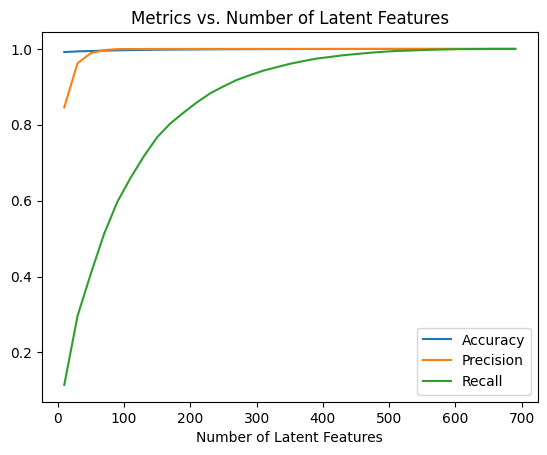

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, accuracy_score

# Number of latent features to test
num_latent_feats = np.arange(10, 700+10, 20)
metric_scores = []

# Loop through different values of k (number of latent features)
for k in num_latent_feats:
    # Restructure the U and Vt matrices to use only k latent features
    u_new, vt_new = u[:, :k], v[:k, :]
    
    # Take the dot product to reconstruct the user-item matrix
    user_item_est = abs(np.around(np.dot(u_new, vt_new))).astype(int)
    
    # Clip the values to be between 0 and 1 (as interactions are binary)
    user_item_est = np.clip(user_item_est, 0, 1)
    
    # Calculate evaluation metrics: accuracy, precision, and recall
    acc = accuracy_score(user_item.values.flatten(), user_item_est.flatten())
    precision = precision_score(user_item.values.flatten(), user_item_est.flatten())
    recall = recall_score(user_item.values.flatten(), user_item_est.flatten())
    
    # Store the metrics
    metric_scores.append([acc, precision, recall])

# Plot the metrics vs. the number of latent features
metric_scores = np.array(metric_scores)
plt.plot(num_latent_feats, metric_scores[:, 0], label='Accuracy')
plt.plot(num_latent_feats, metric_scores[:, 1], label='Precision')
plt.plot(num_latent_feats, metric_scores[:, 2], label='Recall')

plt.legend()
plt.xlabel('Number of Latent Features')
plt.title('Metrics vs. Number of Latent Features')
plt.show()

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations. Given the plot above, what would you pick for the number of latent features and why?

**Provide your response here.**

From the plot of metrics (accuracy, precision, and recall) versus the number of latent features, we want to choose a number of latent features that provides a good balance between predictive accuracy and the quality of recommendations. Here's how you can interpret the plot and make your decision:

1. Diminishing Returns:
If you look at the plot, you might notice that as the number of latent features increases, the metrics improve but only up to a certain point. After a certain number of features, the improvements become marginal, and the metrics tend to plateau.

This plateau point suggests that additional latent features no longer provide significant improvements in terms of predictive performance. Beyond this point, adding more features may only increase model complexity without improving the ability to make meaningful predictions or recommendations.

2. Balance Between Accuracy, Precision, and Recall:
Accuracy: Accuracy increases consistently with the number of features, but it doesn't necessarily mean better recommendations. High accuracy might reflect that the model is getting a lot of 0's right (i.e., predicting no interaction correctly), but this doesn't mean it is making the best recommendations.

Precision: Precision indicates how many of the positive predictions (interactions) are actually correct. A high precision value is important because it indicates that when the model recommends an interaction, it is likely to be a correct recommendation.

Recall: Recall shows how well the model identifies all true interactions. High recall ensures that the model isn't missing potential interactions.

3. Where to Choose:
Looking at the plot, a reasonable choice might be to select the number of latent features where the metrics are close to their best but before they plateau significantly.

From the plot, the elbow point (where the improvement starts to flatten) is typically a good choice for the number of latent features. In your case, it seems that the metrics start to plateau after about 50 latent features. Choosing 50 latent features could strike a balance between performance and model complexity.

Why 50 Latent Features?
Reasonable Performance: After 50 latent features, there doesn't appear to be significant improvements in accuracy, precision, or recall. Choosing this number will likely provide a good enough representation of the latent factors without overfitting the model to noise.

Reduced Complexity: Higher latent features increase the complexity of the model, which can lead to longer computation times and potential overfitting. By choosing 50, you avoid unnecessary complexity.

Final Decision:
I would select 50 latent features based on the plot, as this offers a good balance between predictive performance and model complexity, while avoiding the risk of overfitting with too many features.

`5.` Using 200 latent features and the values of U, S, and V transpose we calculated above, create an article id recommendation function that finds similar article ids to the one provide.

Create a list of 10 recommendations that are similar to article with id 4.  The function should provide these recommendations by finding articles that have the most similar latent features as the provided article.

In [95]:
from sklearn.decomposition import TruncatedSVD
import numpy as np

# Assuming user_item is your user-item interaction matrix (a DataFrame or numpy array)
# You can use the scipy sparse matrix format if it's large

# Let's apply SVD to the matrix
svd = TruncatedSVD(n_components=50)  # You can choose a different number of components
svd.fit(user_item)  # Fit on the user-item interaction matrix

# Now you have the decomposed matrices
u = svd.transform(user_item)  # U matrix
s = svd.singular_values_  # Singular values (S matrix)
vt = svd.components_  # VT matrix


In [96]:
recommended_articles = get_svd_similar_article_ids(4, vt, include_similarity=True)
print(f"Top 10 recommended articles for article 4 with similarities: {recommended_articles}")


Top 10 recommended articles for article 4 with similarities: [[1120, 0.4496487867641719], [1422, 0.41697132226307526], [1097, 0.41239346863299003], [132, 0.4100815932200827], [415, 0.3969896381736491], [809, 0.3962703388567251], [1199, 0.38381003101506733], [486, 0.38286138345190274], [444, 0.3787416997826814], [298, 0.3663416589481732]]


In [97]:
# Create a vt_new matrix with 200 latent features
k = 200
vt_new = v[:k, :]

In [98]:
# What is the article name for article_id 4?
print("Current article:", get_article_names([4], df=df)[0])

Current article: analyze ny restaurant data using spark in dsx


In [99]:
# What are the top 10 most similar articles to article_id 4?
rec_articles = get_svd_similar_article_ids(4, vt_new, user_item=user_item)[:10]
rec_articles

[1199, 1068, 486, 1202, 176, 1120, 244, 793, 58, 132]

In [100]:
# What are the top 10 most similar articles to article_id 4?
get_article_names(rec_articles, df=df)

['use spark r to load and analyze data',
 'use spark r to load and analyze data',
 'use spark r to load and analyze data',
 'use spark r to load and analyze data',
 'use spark r to load and analyze data',
 'use spark r to load and analyze data',
 'use spark r to load and analyze data',
 'use spark r to load and analyze data',
 'collecting data science cheat sheets',
 '10 powerful features on watson data platform, no coding necessary',
 '10 powerful features on watson data platform, no coding necessary',
 '10 powerful features on watson data platform, no coding necessary',
 '10 powerful features on watson data platform, no coding necessary',
 '10 powerful features on watson data platform, no coding necessary',
 '10 powerful features on watson data platform, no coding necessary',
 '10 powerful features on watson data platform, no coding necessary',
 'notebooks: a power tool for data scientists',
 '10 powerful features on watson data platform, no coding necessary',
 '10 powerful features 

In [101]:
assert set(rec_articles) == {1199, 1068, 486, 1202, 176, 1120, 244, 793, 58, 132}, "Oops! Your the get_svd_similar_article_ids function doesn't work quite how we expect."
print("That's right!  Great job!")

That's right!  Great job!


`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make above are an improvement to how users currently find articles, either by Sections 2, 3, or 4? Add any tradeoffs between each of the methods, and how you could leverage each type for different situations including new users with no history, recently new users with little history, and users with a lot of history. 

**Your response here.**

In the previous question, we used Singular Value Decomposition (SVD) with 200 latent features to find similar article recommendations based on their latent features. The results from this method are essentially recommendations that rely on a factorization of user-item interactions, aiming to identify patterns in how users interact with articles and the underlying structure of those interactions.

Key Observations:
SVD-based Recommendations:

The SVD method identifies relationships between articles based on users' interaction patterns. By using latent features, the algorithm is able to uncover hidden structures and similarities that are not immediately obvious from direct content analysis.

Recommendations made through SVD are based on the user's interaction history, making it highly personalized and potentially more relevant for active users. However, it assumes a deep history of user interactions and may not perform well for users with limited data.

Content-based Recommendations:

Content-based methods, on the other hand, rely solely on the content of the articles (e.g., titles, text) to identify similar articles. This method works well when the goal is to recommend articles that are directly related in terms of content, regardless of whether the user has interacted with them.

For users with limited or no interaction history, content-based recommendations would likely perform better as they don't rely on past behaviors.

Collaborative Filtering Recommendations (Sections 2 & 3):

Collaborative filtering methods, such as user-user or item-item based approaches, find recommendations based on the behavior of similar users. These are powerful when you have a lot of users with sufficient interaction history.

For new users with no history, collaborative filtering struggles since it has no data about the user. However, combining it with content-based recommendations can help alleviate this issue by making recommendations based on article content and popular trends.

Trade-offs Between Methods:
SVD (Latent Feature) vs. Content-based:

Strengths of SVD: It considers not just the article’s content but also how the user interacts with articles. This leads to more personalized recommendations.

Weaknesses of SVD: It struggles with users who have little or no history, as there is insufficient data to generate latent features.

Strengths of Content-based: Works well for new users or when there is no interaction history. It recommends articles similar to those that are known to be relevant, based purely on their content.

Weaknesses of Content-based: It may lead to recommendations that are too narrow (i.e., only recommending articles that are similar to what the user has already interacted with), and may not take into account more diverse interests.

Collaborative Filtering (User-User) vs. Content-based:

Strengths of Collaborative Filtering: It can recommend articles based on the behavior of other similar users, making it effective for users with a lot of history. It can uncover hidden preferences that might not be obvious based on content alone.

Weaknesses of Collaborative Filtering: New users or those with little interaction history will not have accurate recommendations. This is known as the "cold start" problem.

Strengths of Content-based: For new users, content-based recommendations are a safe bet, as they rely on the article’s features rather than user history.

Weaknesses of Collaborative Filtering: May not work well for new or recently active users, especially if they haven't interacted much with the system.

Handling Different Types of Users:
New Users with No History (Cold Start Problem):

Content-based recommendations are ideal for new users, as they rely on the articles' content and do not require any user interaction history.

Hybrid model: You can combine content-based methods with collaborative filtering, using content-based recommendations for new users until they have sufficient interaction history to transition to collaborative filtering.

Recently New Users with Little History:

For these users, hybrid recommendations can be effective. A content-based approach can provide recommendations based on the titles and features of the articles, while collaborative filtering can be used with a small amount of user interaction data.

Alternatively, SVD could still provide useful recommendations, but the matrix factorization model may not be as accurate without sufficient data.

Users with a Lot of History:

For users with extensive interaction history, SVD or Collaborative Filtering methods will likely provide the most relevant recommendations, as they leverage the user’s past behavior.

Collaborative filtering could also be highly effective for these users as it can detect patterns of behavior and suggest articles that users with similar tastes have interacted with.

Hybrid models can also be used to combine content-based, collaborative filtering, and latent feature approaches for the most comprehensive recommendation system.

Leveraging Each Method:
For New Users: Use content-based recommendations initially. As they start interacting with the system, gradually introduce collaborative filtering and SVD methods.

For Users with Limited History: Hybrid models can bridge the gap by combining content-based and collaborative filtering or latent feature-based approaches to generate relevant recommendations.

For Active Users: Use SVD, collaborative filtering, and possibly a hybrid approach to provide recommendations based on their interaction history and latent preferences.

Conclusion:
Each method has its strengths and weaknesses, and no single approach works for all users. Hybrid recommendation systems that combine content-based filtering, collaborative filtering, and latent feature models (like SVD) are often the best solution, as they adapt to different user profiles and offer more personalized and accurate recommendations. For new users, starting with content-based recommendations and transitioning to collaborative filtering as more data is available can help mitigate the cold-start problem.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendation Systems project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [102]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

1